In [1]:
import numpy as np
from keras import models, layers
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from capsnetKeras.capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

Using TensorFlow backend.


In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16


In [3]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.set_random_seed(seed)

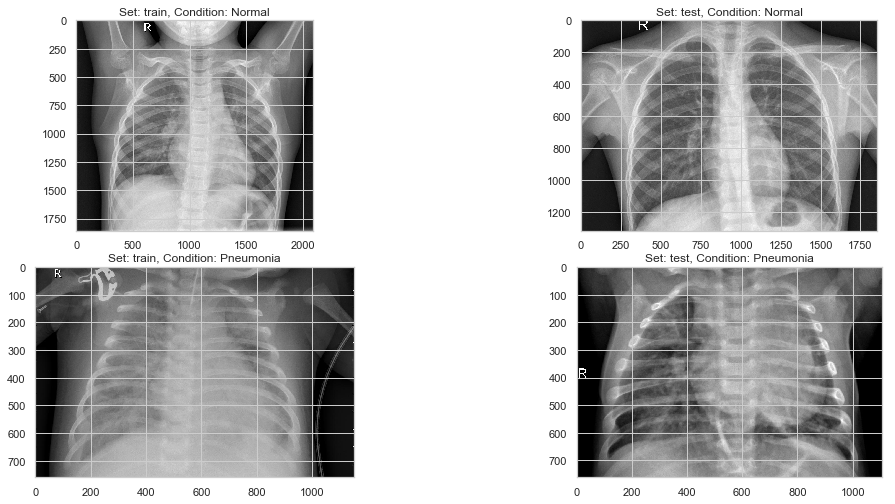

In [4]:
input_path = './chest_xray/'

fig, ax = plt.subplots(2, 2, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+2].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [5]:
input_path = './chest_xray/'

for _set in ['train', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1108, pneumonia images: 2992
Set: test, normal images: 475, pneumonia images: 1282


In [6]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range = 40, 
                                       width_shift_range = 0.2, 
                                       height_shift_range = 0.2, 
                                       shear_range = 0.2,
                                       zoom_range=0.2, 
                                       horizontal_flip=True)
    
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [8]:
img_dims = 200
epochs = 200
batch_size = 16

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)


Found 4101 images belonging to 2 classes.
Found 1757 images belonging to 2 classes.


ValueError: could not broadcast input array from shape (200,200,3) into shape (200,200)

In [ ]:
import numpy as np
from keras import models, layers
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from capsnetKeras.capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

In [ ]:
np.set_printoptions(threshold=np.nan)

number_of_classes = 2
input_shape = (100, 100, 1)

x = layers.Input(shape=input_shape)
'''
First layer is a convolutional layer with 100 × 7 × 7 filters and stride of 1 which leads to 64 feature maps of size 56×56.
'''
conv1 = layers.Conv2D(100, (3, 3), activation='relu', name="FirstLayer")(x)
'''
The second layer is a Primary Capsule layer resulting from 128×7×7 convolutions with strides of 1.
'''
primaryCaps = PrimaryCap(inputs=conv1, dim_capsule=8, n_channels=16, kernel_size=3, strides=2, padding='valid')
'''
Final capsule layer includes 2 capsules, referred to as “Class Capsules,’ ’one for each of 2 classes. The dimension of these capsules is 16.
'''
capLayer2 = CapsuleLayer(num_capsule=2, dim_capsule=16, routings=2, name="ThirdLayer")(primaryCaps)

# Layer 4: This is an auxiliary layer to replace each capsule with its
# length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
out_caps = Length(name='capsnet')(capLayer2)


# Decoder network.
y = layers.Input(shape=(number_of_classes,))
# The true label is used to mask the output of capsule layer. For training
masked_by_y = Mask()([capLayer2, y])
# Mask using the capsule with maximal length. For prediction
masked = Mask()(capLayer2)


# Shared Decoder model in training and prediction
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(512, activation='relu',input_dim=16 * number_of_classes))
decoder.add(layers.Dense(1024, activation='relu'))
decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

# Models for training and evaluation (prediction)
train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])


print(train_model.summary())

In [59]:
def create_generator(data_directory, batch_size=16):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range = 40, 
                                       width_shift_range = 0.2, 
                                       height_shift_range = 0.2, 
                                       shear_range = 0.2,
                                       zoom_range=0.2, 
                                       horizontal_flip=True)
    image_resize_height = 100
    image_resize_width = 100

    generator = train_datagen.flow_from_directory(
        data_directory,
        color_mode='grayscale',
        target_size=(image_resize_height, image_resize_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True)

    while 1:
        x_batch, y_batch = generator.next()
        yield ([x_batch, y_batch], [y_batch, x_batch])


In [60]:
def create_test_generator(data_directory, batch_size=16):
    train_datagen = ImageDataGenerator(rescale=1./255)
    image_resize_height = 100
    image_resize_width = 100

    generator = train_datagen.flow_from_directory(
        data_directory,
        color_mode='grayscale',
        target_size=(image_resize_height, image_resize_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True)

    while 1:
        x_batch, y_batch = generator.next()
        yield ([x_batch, y_batch], [y_batch, x_batch])

In [61]:
input_path = './chest_xray/'

train_data_directory = input_path+'train/'
validation_data_directory = input_path+'test/'
bsize = 16

train_generator = create_generator(train_data_directory, 
                                   batch_size=bsize)

validation_generator = create_test_generator(validation_data_directory,
                                        batch_size=bsize)


In [62]:
train_model.compile(optimizer="rmsprop",loss='mse',metrics=['accuracy'])

In [63]:
checkpointer1 = ModelCheckpoint(filepath='./Models/CapsNet.hdf5', 
                               verbose=1, 
                               monitor='val_capsnet_acc', 
                               mode='max',
                               save_best_only=True) 

es2 = EarlyStopping(
    monitor='val_capsnet_acc', 
    mode='max',
    patience=50)


In [64]:
import gc
gc.collect()

3124

In [65]:
hist = train_model.fit_generator(
           train_generator, steps_per_epoch=128, 
           epochs=epochs, validation_data=validation_generator, 
           validation_steps=32, verbose = 1, callbacks=[checkpointer1, es2])

Epoch 1/200
Found 640 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
163/163 [==============================] - 104s 638ms/step - loss: 0.1471 - capsnet_loss: 0.1217 - decoder_loss: 0.0254 - capsnet_acc: 0.8436 - decoder_acc: 0.0628 - val_loss: 0.2327 - val_capsnet_loss: 0.2023 - val_decoder_loss: 0.0303 - val_capsnet_acc: 0.6750 - val_decoder_acc: 0.0461

Epoch 00001: val_capsnet_acc improved from -inf to 0.67500, saving model to ./Models/CapsNet.hdf5
Epoch 2/200
163/163 [==============================] - 104s 636ms/step - loss: 0.1400 - capsnet_loss: 0.1163 - decoder_loss: 0.0237 - capsnet_acc: 0.8566 - decoder_acc: 0.0641 - val_loss: 0.2171 - val_capsnet_loss: 0.1927 - val_decoder_loss: 0.0244 - val_capsnet_acc: 0.7312 - val_decoder_acc: 0.0470

Epoch 00002: val_capsnet_acc improved from 0.67500 to 0.73125, saving model to ./Models/CapsNet.hdf5
Epoch 3/200
163/163 [==============================] - 110s 677ms/step - loss: 0.1430 - capsnet_loss: 0.1199 - dec

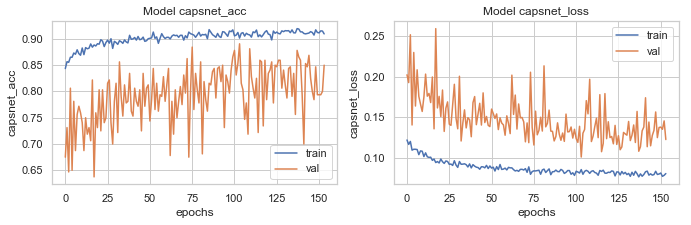

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['capsnet_acc', 'capsnet_loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

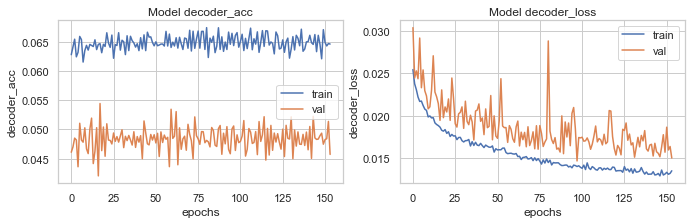

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['decoder_acc', 'decoder_loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

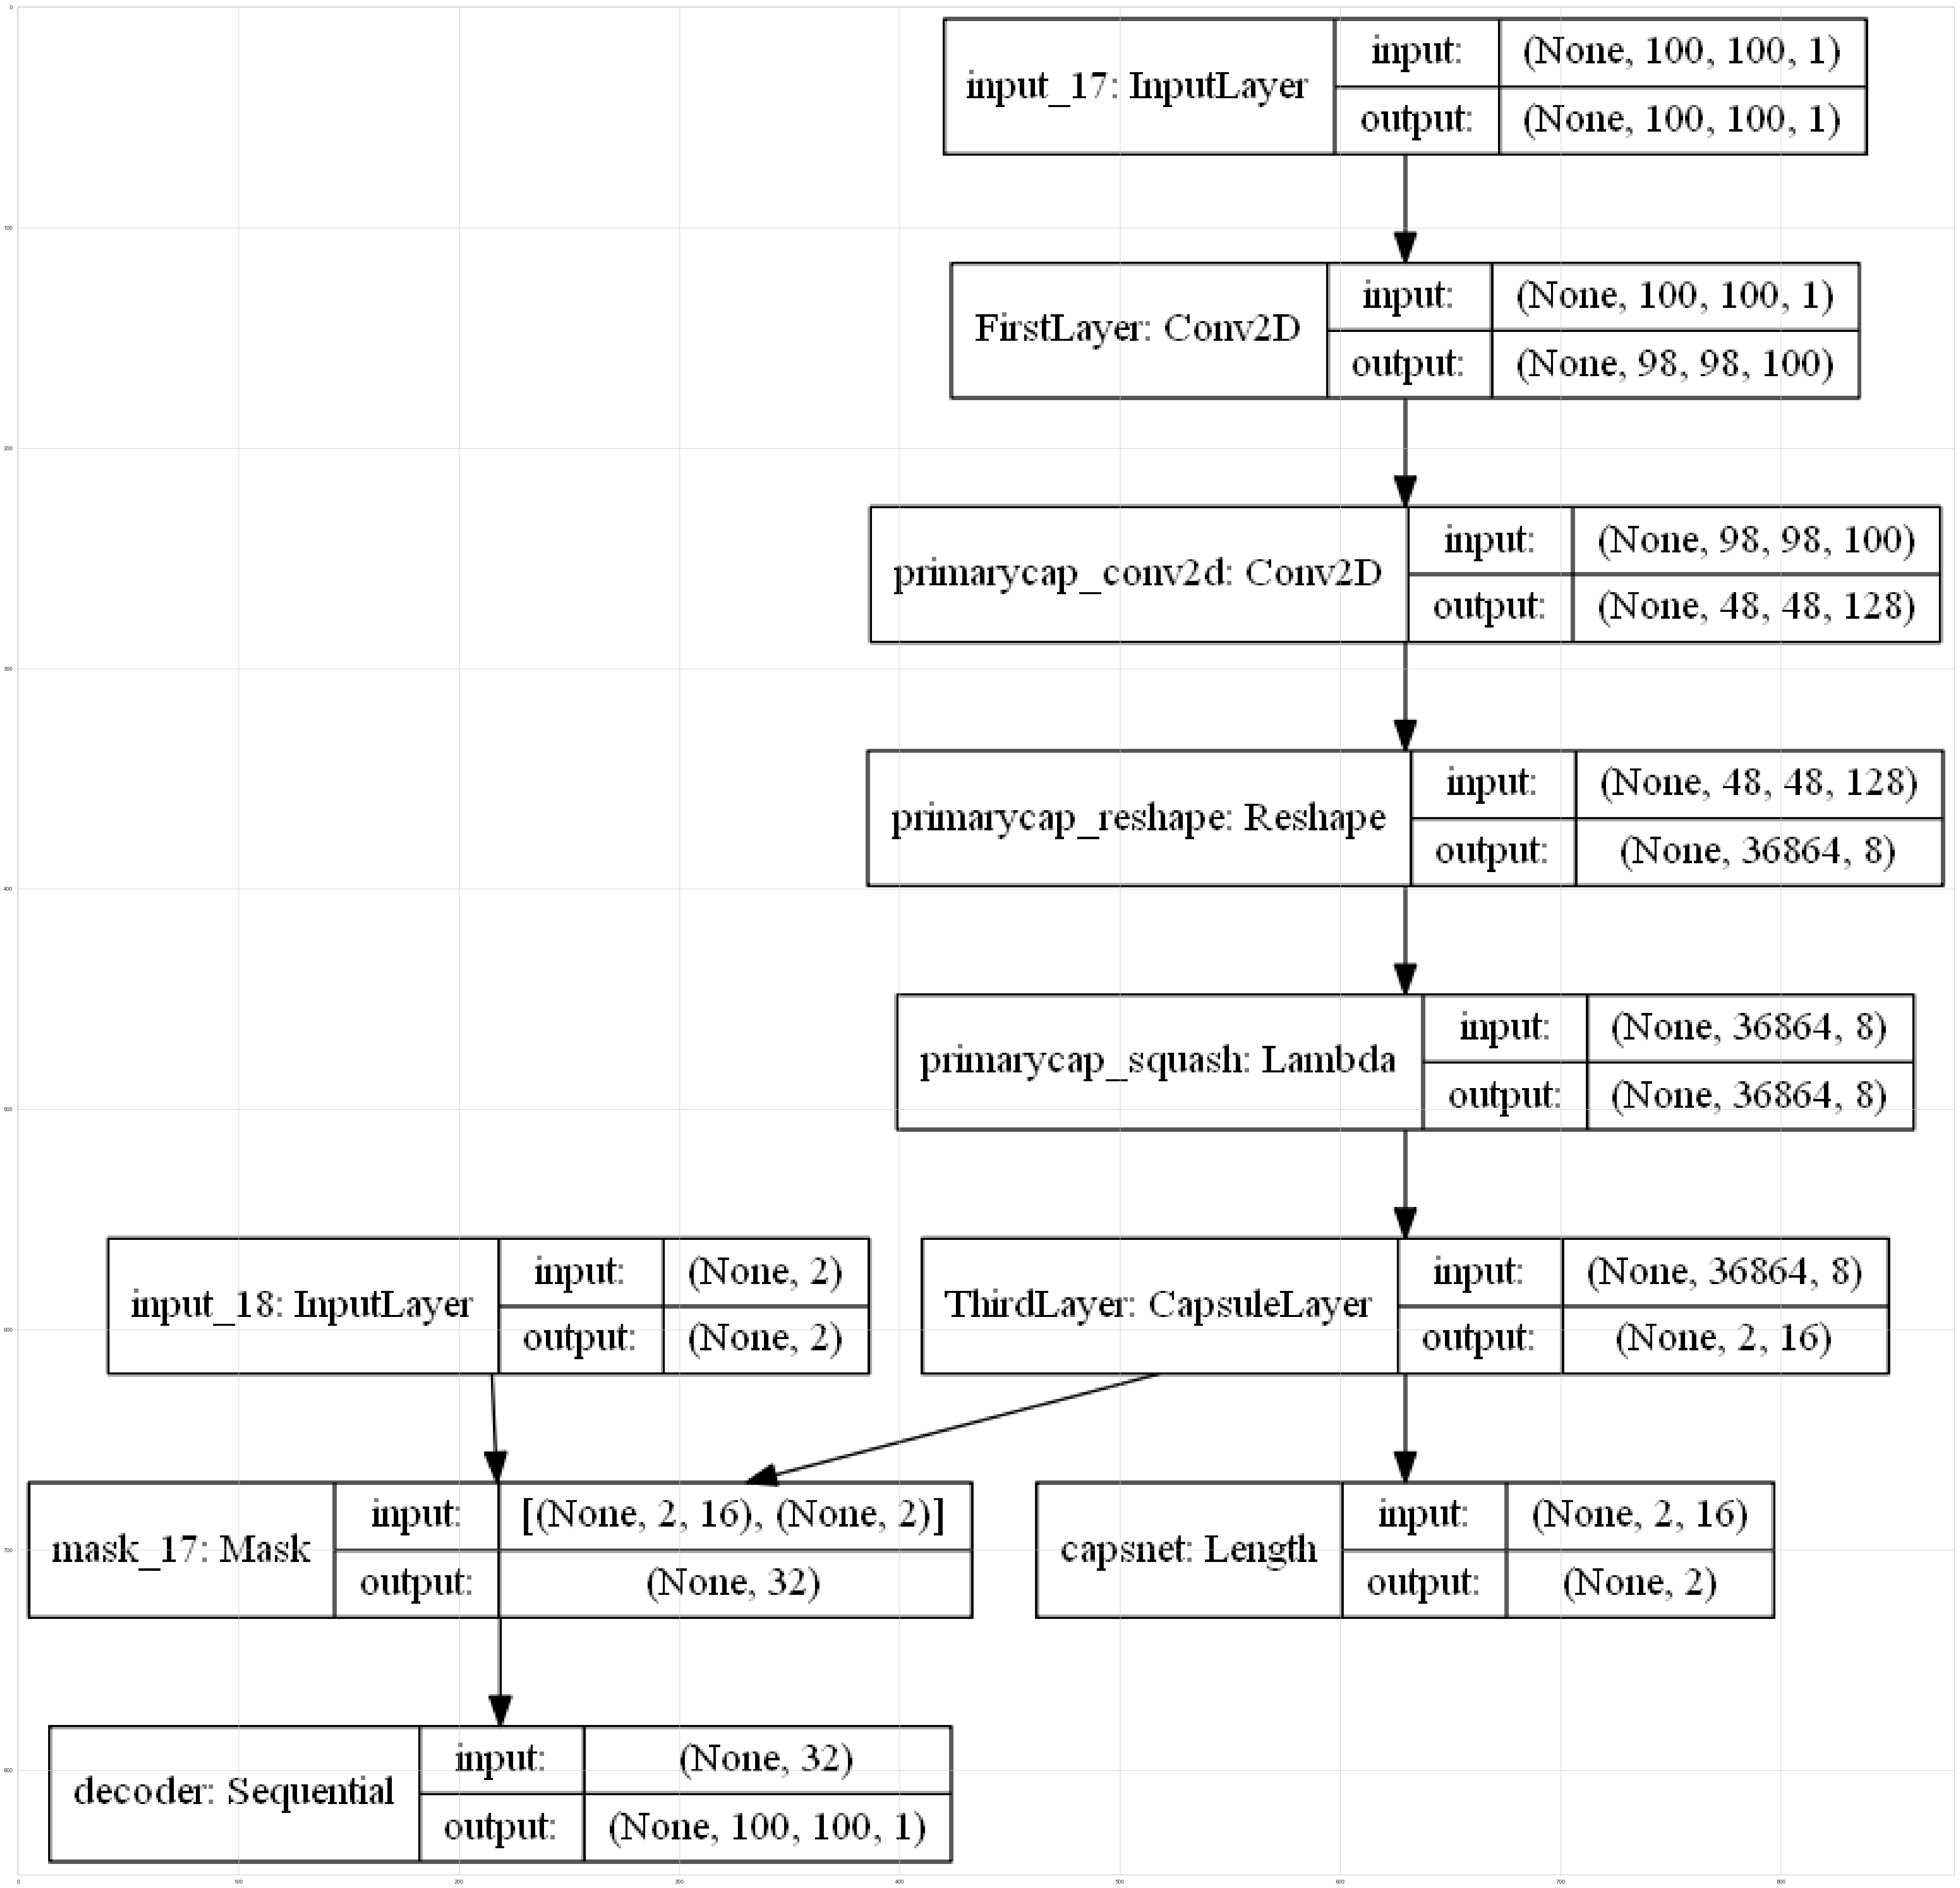

In [70]:
%matplotlib inline
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

plot_model(train_model, to_file='CapsNet.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('CapsNet.png')
plt.figure(figsize=(100,70))
imgplot = plt.imshow(img)